# Introduction: Transfer Learning in PyTorch

In this notebook, we'll see how to use PyTorch to train a classifier to identify 101 different objects in images. Through this project, we'll get familiar with the basics of transfer learning, PyTorch, convolutional neural networks, and inference. 

## Dataset: CalTech 101

The dataset is the [CalTech 101 collection](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) of images from 101 categories. There are about 40 to 800 images in each category. I've reduced the number of categories to 100 and arranged them in three sets: train, valid, test with a split of 50%, 25%, and 25%. 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

### Parameters

The parameters in this cell can be changed as needed. I'm going to be training with 2 gpus in parallel, but your setup will probably be different. One of the benefits of using PyTorch is we can easily move different elements of the model or data to cpus/gpus or to multiple gpus. Granted, we probably won't always have many gpus, but when we do, we want to make the best use of them! 

In [2]:
# Location of data
datadir = '/home/wjk68/'
traindir = datadir + 'train/'
validdir = datadir + 'valid/'
testdir = datadir + 'test/'

save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'

# Change to fit hardware
batch_size = 128

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
2 gpus detected.


## Data Exploration

We can do a brief exploration of the available images. There are a total of 100 categories, which I've already split into training (50%), validation (25%), and testing (25%) folders. The data is clean and each class (I use the terms "class" and "category" interchangeably in this notebook) is stored in a separate folder. The architecture of the folders is thus:

```
/datadir
    /train
            /class_1
            /class_2
            .
            .
    /valid
            /class_1
            /class_2
            .
            .
    /test
            /class_1
            /class_2
            .
            .
```
This is a standard organization of the data for cnns and makes it simple to associate the correct labels with the images.

Below we take a look at the number of images in each category and the size of the images.

In [3]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()
cat_df.tail()

category  n_train  n_valid  n_test
4    airplanes      400      200     200
2   motorbikes      398      200     200
0        faces      274      138     109
93       watch      119       60      60
1     leopards      100       50      50

category  n_train  n_valid  n_test
63     metronome       16        8       8
72      platypus       16        9       9
42      garfield       16        9       9
96      wild_cat       16        9       9
51  inline_skate       15        8       8

#### Distribution of Images

There are between 400 and 15 training images in each category. The low number of training images may result in reduced scores in some categories.

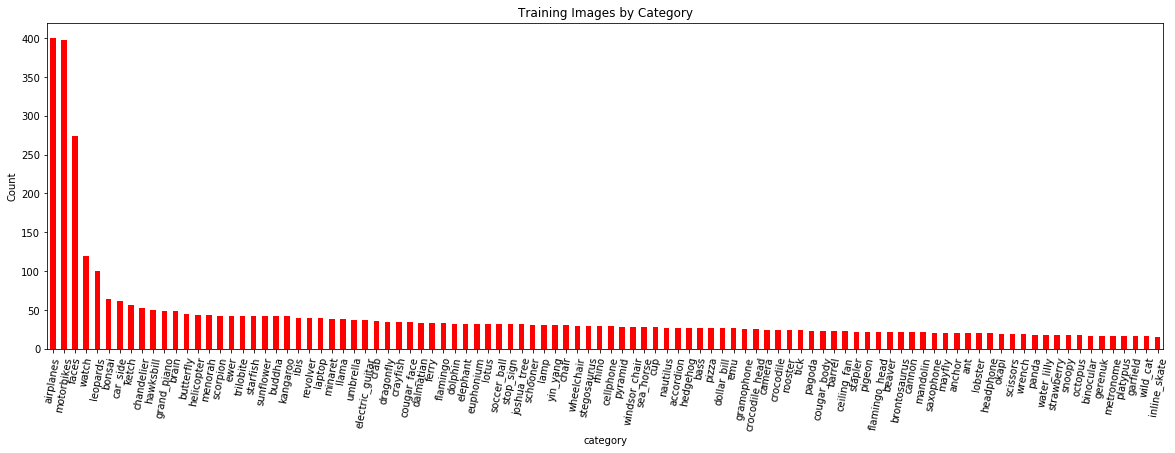

In [4]:
cat_df.set_index('category')['n_train'].plot.bar(
    color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

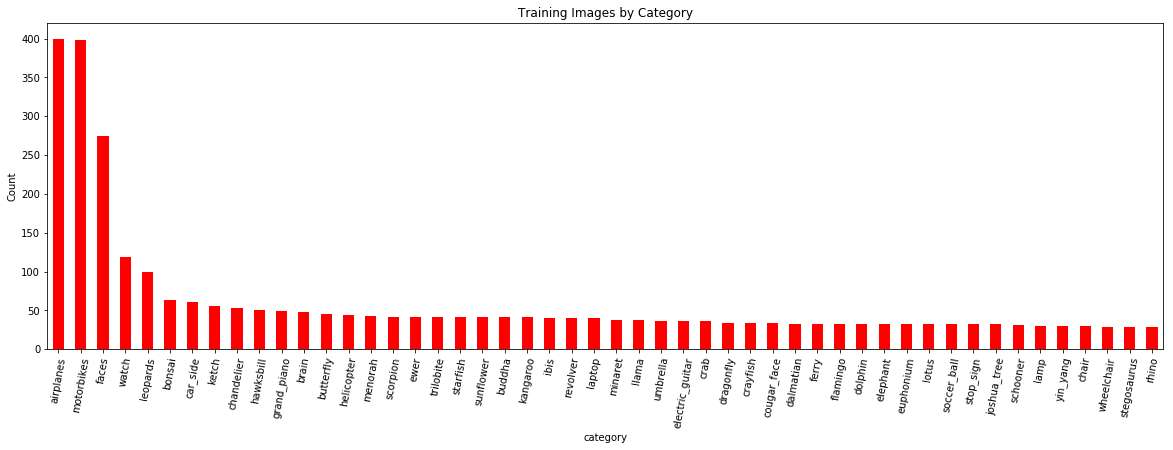

In [5]:
# Only top 50 categories
cat_df.set_index('category').iloc[:50]['n_train'].plot.bar(
    color='r', figsize=(20, 6))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

I'm guessing the categories with more examples will be easier to learn. One way we partially get around the small number of images is through data augmentation (which we'll see in a bit).

#### Distribution of Images Sizes

The images themselves have vastly different shapes. We can see this by looking at the stats of images sizes by category.

In [6]:
img_dsc = image_df.groupby('category').describe()
img_dsc.head()

height                                                              \
           count        mean        std    min     25%    50%     75%    max   
category                                                                       
accordion   27.0  263.851852  35.769243  199.0  233.00  265.0  300.00  300.0   
airplanes  400.0  158.455000  30.847397  101.0  141.00  154.0  170.25  494.0   
anchor      20.0  241.000000  38.608698  170.0  219.75  236.0  264.50  300.0   
ant         20.0  211.950000  47.137509  103.0  177.00  203.0  236.75  300.0   
barrel      23.0  284.086957  36.455344  188.0  300.00  300.0  300.00  300.0   

           width                                                            
           count        mean        std    min    25%    50%    75%    max  
category                                                                    
accordion   27.0  280.333333  30.849511  209.0  266.5  300.0  300.0  300.0  
airplanes  400.0  402.137500   8.804965  356.0  396.0  401.0  406.0  457.0  
anchor      20.0  291.300000  22.209766  230.0  300.0  300.0  300.0  300.0  
ant         20.0  298.600000   6.029751  273.0  300.0  300.0  300.0  300.0  
barrel      23.0  241.869565  41.592508  168.0  205.5  235.0  283.0  300.0

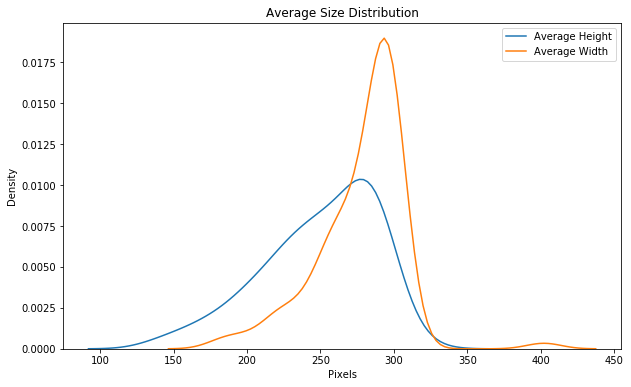

In [7]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    img_dsc['height']['mean'], label='Average Height')
sns.kdeplot(
    img_dsc['width']['mean'], label='Average Width')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Average Size Distribution')

When we use the images in the pre-trained network, we'll have to reshape them to 224 x 224. This is the size of Imagenet images and is therefore what the model expects. The images that are larger than this will be truncated while the smaller images will be interpolated. 

(300, 187, 3)

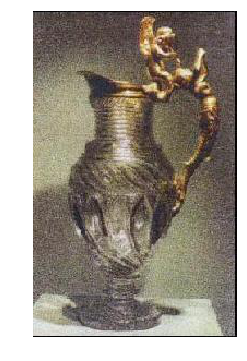

In [8]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Example image
x = Image.open(traindir + 'ewer/image_0002.jpg')
np.array(x).shape
imshow(x)

(300, 285, 3)

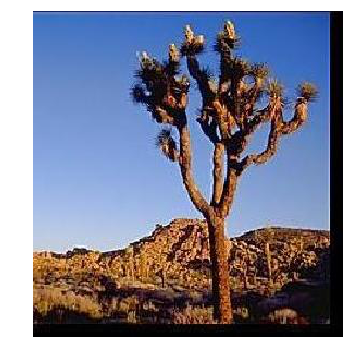

In [9]:
x = Image.open(traindir + 'joshua_tree/image_0002.jpg')
np.array(x).shape
imshow(x)

# Image Preprocessing

To prepare the images for our network, we have to resize them to 224 x 224 and normalize each color channel by subtracting a mean value and dividing by a standard deviation. We will also augment our training data in this stage. These operations are done using image `transforms`, which prepare our data for a neural network.

### Data Augmentation

Because there are a limited number of images in some categories, we can use image augmentation to artificially increase the number of images "seen" by the network. This means for training, we randomly resize and crop the images and also flip them horizontally. A different random transformation is applied each epoch (while training), so the network effectively sees many different versions of the same image. All of the data is also converted to Torch `Tensor`s before normalization. The validation and testing data is not augmented but is only resized and normalized. The normalization values are standardized for Imagenet. 

In [10]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Examples of Augmentation

To show how augmentation works, we need to write a function that will plot a tensor as an image.

In [11]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

We'll work with two example images and apply the train transformations.

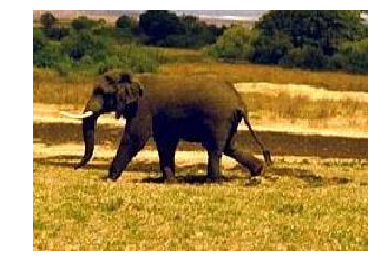

In [12]:
ex_img = Image.open('/home/wjk68/train/elephant/image_0024.jpg')
imshow(ex_img)

<Figure size 1728x1728 with 0 Axes>

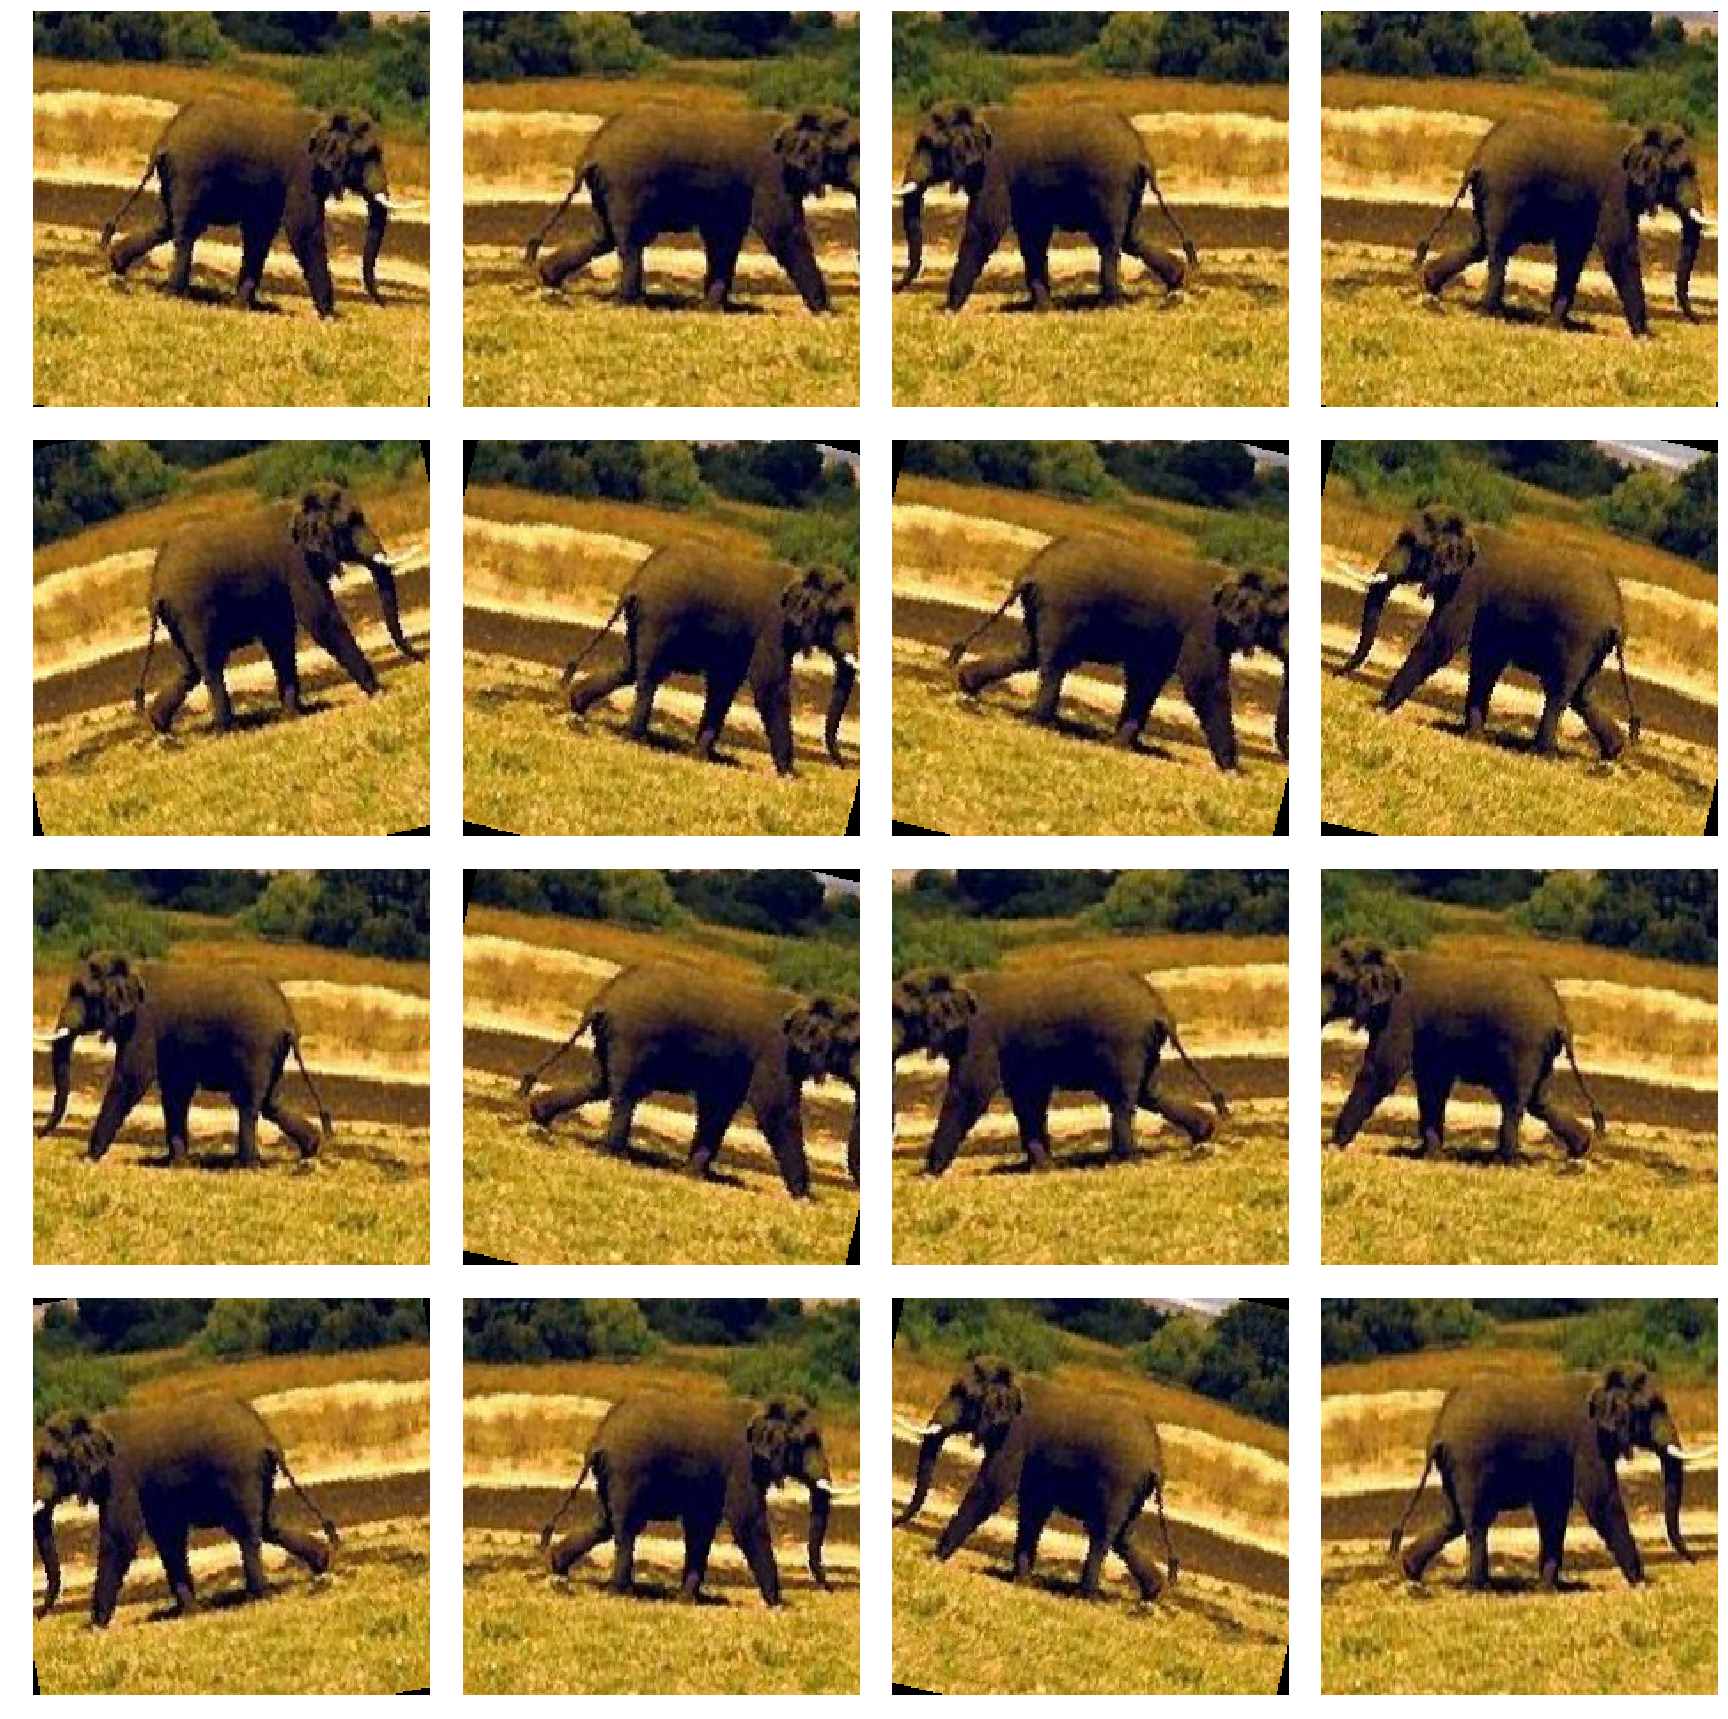

In [13]:
t = image_transforms['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

<Figure size 1728x1728 with 0 Axes>

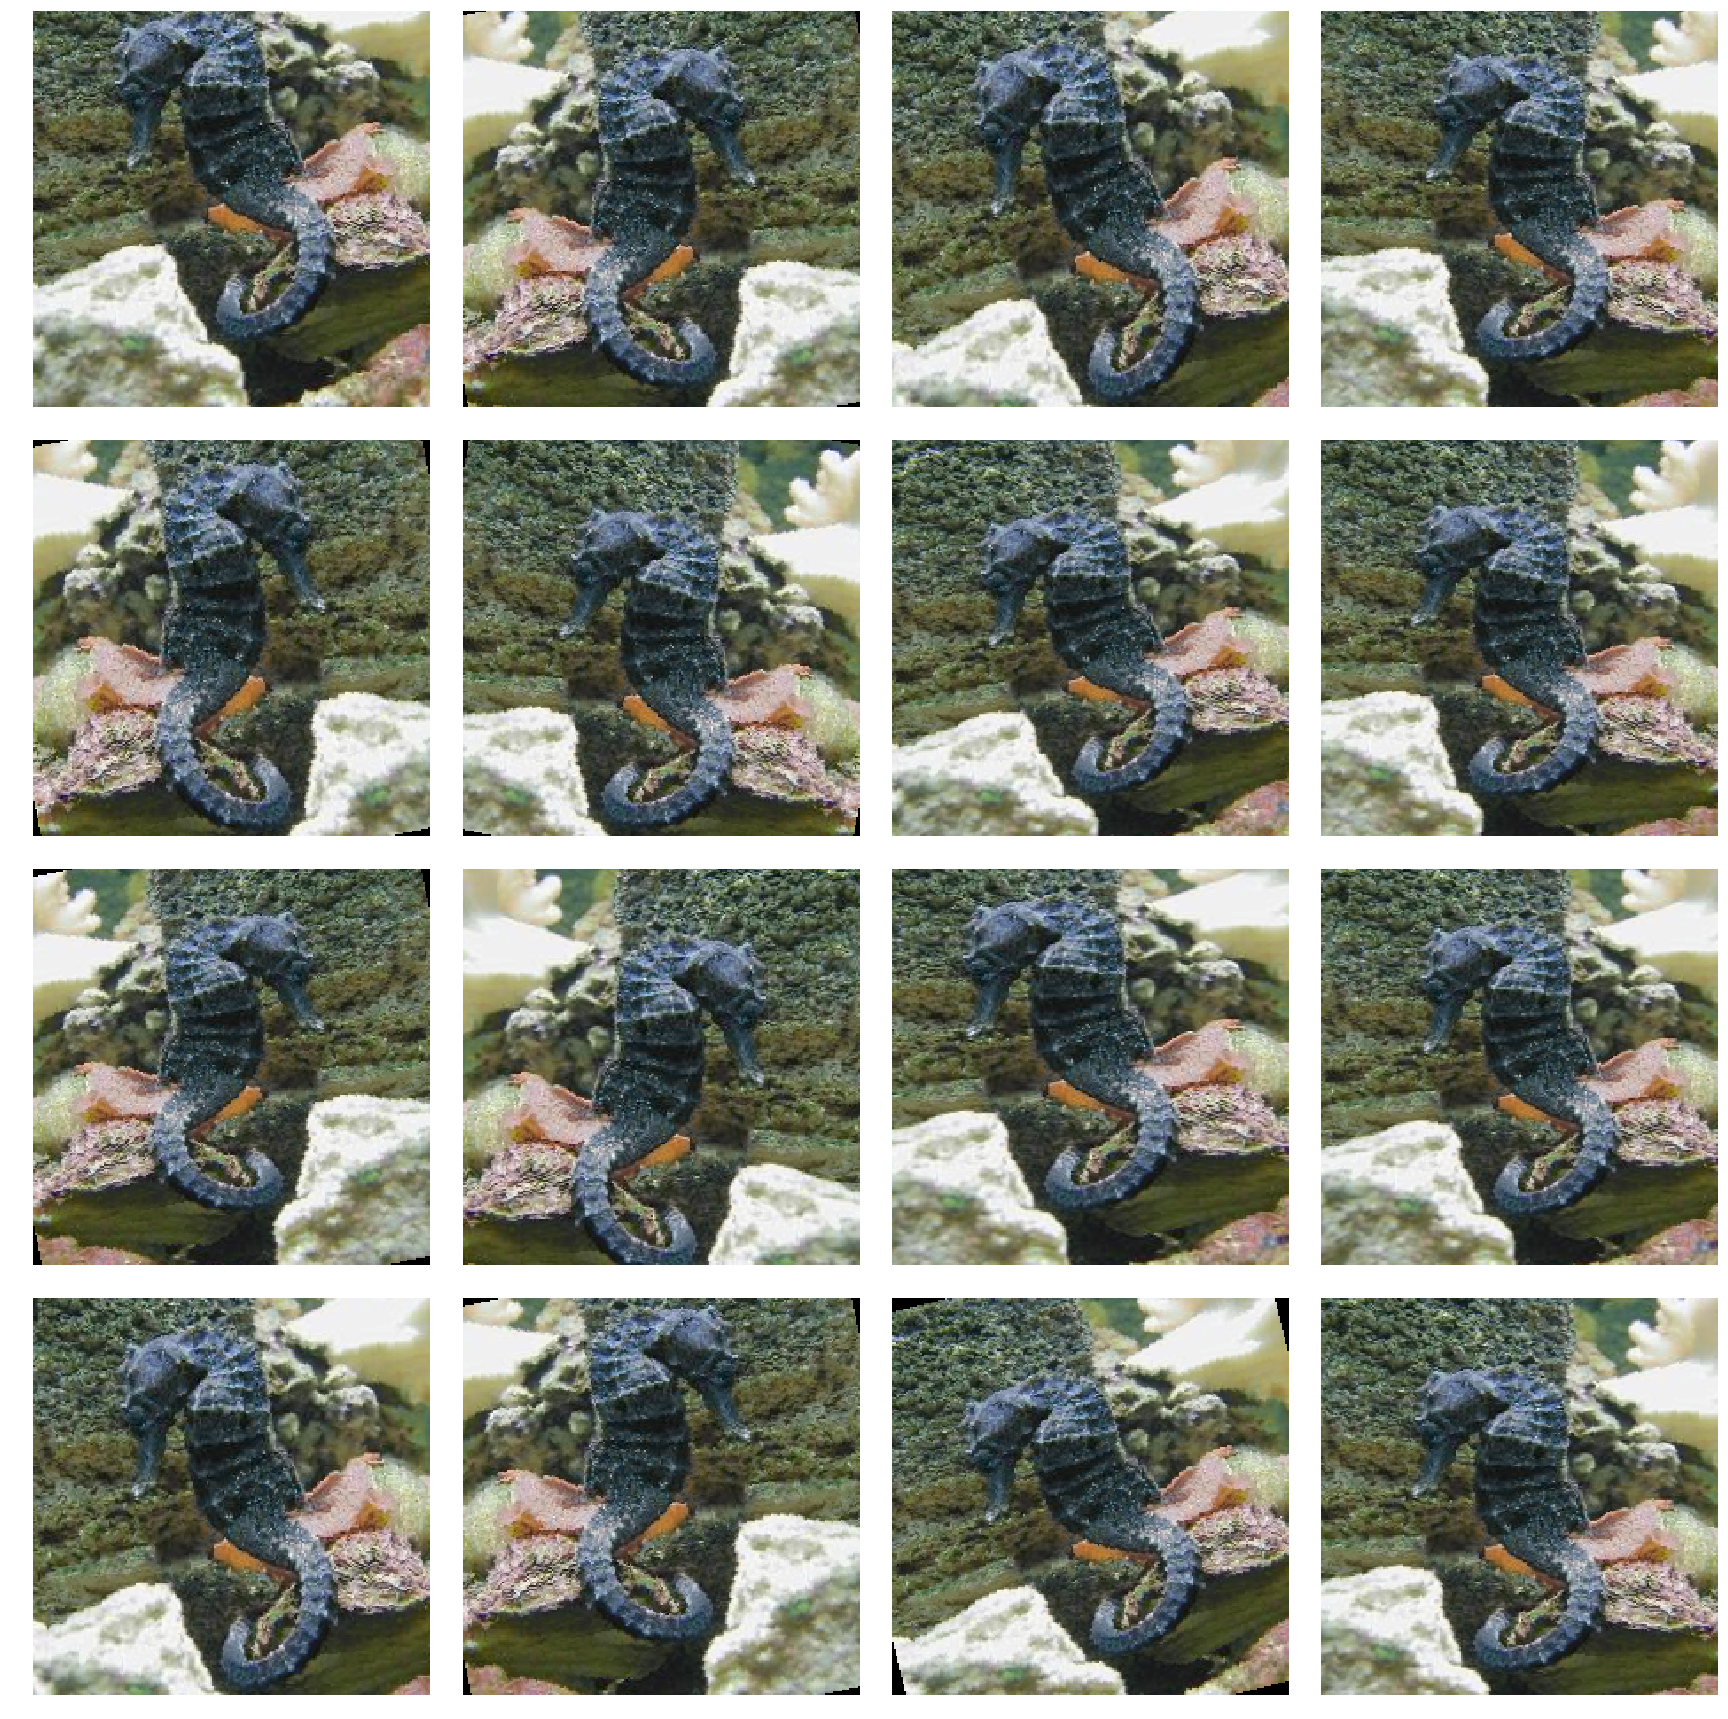

In [14]:
ex_img = Image.open('/home/wjk68/train/sea_horse/image_0056.jpg')
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

## Data Iterators

To avoid loading all of the data into memory at once, we use training `DataLoaders`. First, we create a dataset object from the image folders, and then we pass these to a `DataLoader`. At training time, the `DataLoader` will load the images from disk, apply the transformations, and yield a batch. To train and validation, we'll iterate through all the batches in the respective `DataLoader`. 

One crucial aspect is to `shuffle` the data before passing it to the network. This means that the ordering of the image categories changes on each pass through the data (one pass through the data is one training epoch). 

In [15]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [16]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

The shape of a batch is `(batch_size, color_channels, height, width)`. 

There should be 100 different classes. We can confirm this as follows.

In [17]:
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

There are 100 different classes.


100

We can iterate through the `DataLoaders` when doing training, validation, and testing. This construction avoids the need to load all the data into memory and also will automatically apply the transformations to each batch. On each epoch, the `Random` transformations will be different so the network will essentially see multiple versions of each training image. 

# Pre-Trained Models for Image Classification

PyTorch has many pretrained models we can use. All of these models have been trained on Imagenet which consists of millions of images across 1000 categories. What we want to do with pretrained models is freeze the early layers, and replace the classification module with our own. 

## Approach

The approach for using a pre-trained image recognition model is well-established:

1. Load in pre-trained weights from a network trained on a large dataset
2. Freeze all the weights in the lower (convolutional) layers
    * Layers to freeze can be adjusted depending on similarity of task to large training dataset
3. Replace the classifier (fully connected) part of the network with a custom classifier
    * Number of outputs must be set equal to the number of classes
4. Train only the custom classifier (fully connected) layers for the task
    * Optimizer model classifier for smaller dataset
    
The idea behind pre-training is the early convolutional layers of a cnn extract features that are relevant for many image recognition tasks. The later, fully-connected layers, specialize to the specific dataset by learning higher-level features. Therefore, we can use the already trained convolutional layers while training only the fully-connected layers on our own dataset. Pre-trained networks have proven to be reasonably successful for a variety of tasks, and result in a significant reduction in training time and usually increases in performance. 

The models available in PyTorch are listed below with the corresponding number of parameters.

In [18]:
model_options = pd.read_csv('models.csv')
model_options

model     params
0         AlexNet   61100840
1        DenseNet    7978856
2      Inception3   27161264
3      SqueezeNet    1248424
4         alexnet   61100840
5     densenet121    7978856
6     densenet161   28681000
7     densenet169   14149480
8     densenet201   20013928
9    inception_v3   27161264
10      resnet101   44549160
11      resnet152   60192808
12       resnet18   11689512
13       resnet34   21797672
14       resnet50   25557032
15  squeezenet1_0    1248424
16  squeezenet1_1    1235496
17          vgg11  132863336
18       vgg11_bn  132868840
19          vgg13  133047848
20       vgg13_bn  133053736
21          vgg16  138357544
22       vgg16_bn  138365992
23          vgg19  143667240
24       vgg19_bn  143678248

We'll be using the `vgg16` although the code also has support for the `resnet50`. You can modify the code to use a different network quite easily. The VGG networks had very good performance without taking a long time to train. 

## Process to Use Pre-Trained Model

We'll illustrate the process by using one model, vgg16.

First off, load in the model with pretrained weights. 

In [19]:
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

The `classifier` is the part of the model that we'll train. However, for the vgg, we'll only need to train the last few layers in the classifier and not even all of the fully connected layers. 

### Freeze Early layers

We freeze all of the existing layers in the network by setting `requires_grad` to `False`. 

In [20]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

### Add on Custom Classifier

We'll train a classifier consisting of the following layers

* Fully connected with ReLU activation (n_inputs, 256)
* Dropout with 40% chance of dropping
* Fully connected with log softmax output (256, n_classes)

To build our custom classifier, we use the `nn.Sequential()` module which allows us to specify each layer one after the other. We assign our custom classifier to the final `classifier` layer in the already trained vgg network. When we add on the extra layers, they are set to `require_grad=True` by default. These will be the only layers that are trained. 

In [21]:
n_inputs = model.classifier[6].in_features

# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4)
    (3): Linear(in_features=256, out_features=100, bias=True)
    (4): LogSoftmax()
  )
)

The final output will be log probabilities which we can then use in the Negative Log Likelihood Loss. 

In [22]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,335,076 total parameters.
1,074,532 training parameters.


Even with only a few layers set to trainable, there are still over a million parameters (weights) that will be updated during training. In effect, we are _fine-tuning_ the model to work on our problem. We already know it works well on Imagenet, and because our images are relatively similar, we should expect the model to easily _transfer_ its knowledge from Imagenet to our dataset.

### Move to GPU 

To use a gpu in PyTorch, we simply move the whole model onto the gpu. Later we'll have to move the data to gpus in our training loop.

Since I am using multiple gpus, I also distribute the model across both of them with `nn.DataParallel`. 

In [23]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

## Function to Load in Pretrained Model

We can refactor all that code into a single function that returns a pretrained model. This only accepts the vgg16 or resnet50 at the moment but can be extended to use other models. 

In [24]:
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    if multi_gpu:
        model = nn.DataParallel(model)

    return model

This should return the same as the pretrained model with the custom classifier. In the case of resnet, we replace the `fc` layers with the same classifier.

The `torchsummary` library has a helpful function called `summary` which summarizes our model.

In [25]:
model = get_pretrained_model('vgg16')
if multi_gpu:
    summary(
        model.module,
        input_size=(3, 224, 224),
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 256, 56, 56]         590,080
             ReLU-14         [128, 256,

We can see that the model is quite large and training all of the layers would take a considerable time. Even with only a few layers to train, this can still take a while to train. You might need to decrease the `batch_size` if this is not fitting on your gpu (hopefully you have one).

In [26]:
if multi_gpu:
    print(model.module.classifier[6])
else:
    print(model.classifier[6])

Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=256, out_features=100, bias=True)
  (4): LogSoftmax()
)


#### Mapping of Classes to Indexes

To keep track of the predictions made by the model, we create a mapping of classes to indexes and indexes to classes. This will let us know the actual class for a given prediction.

In [27]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'accordion'),
 (1, 'airplanes'),
 (2, 'anchor'),
 (3, 'ant'),
 (4, 'barrel'),
 (5, 'bass'),
 (6, 'beaver'),
 (7, 'binocular'),
 (8, 'bonsai'),
 (9, 'brain')]

# Training Loss and Optimizer

The loss is the negative log likelihood and the optimizer is the Adam optimizer. The negative log likelihood in PyTorch expects log probabilities so we need to pass it the raw output from the log softmax in our model's final layer. The optimizer is told to optimizer the model parameters (only a few of which require a gradient). 

* Loss (criterion): keeps track of the loss itself and the gradients of the loss with respect to the model parameters (weights)
* Optimizer: updates the parameters (weights) with the gradients 

In [28]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

Below we can look at the parameters (weights) that will be updated by the optimizer during training.

In [29]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([100, 256])
torch.Size([100])


# Training

For training, we iterate through the train `DataLoader`, each time passing one batch through the model. One complete pass through the training data is known as an `epoch`, and we train for a set number of epochs or until early stopping kicks in (more below). After each batch, we calculate the loss (with `criterion(output, targets)`) and then calculate the gradients of the loss with respect to the model parameters with `loss.backward()`. This uses autodifferentiation and backpropagation to calculate the gradients. 

After calculating the gradients, we call `optimizer.step()` to update the model parameters with the gradients. This is done on every training batch so we are implementing stochastic gradient descent (or rather a version of it with momentum known as Adam). For each batch, we also compute the accuracy for monitoring and after the training loop has completed, we start the validation loop. This will be used to carry out early stopping.


## Early Stopping

Early stopping halts the training when the validation loss has not decreased for a number of epochs. Each time the validation loss does decrease, the model weights are saved so we can later load in the best model. Early stopping is an effective method to prevent overfitting on the training data. If we continue training, the training loss will continue to decrease, but the validation loss will increase because the model is starting to memorize the training data. Early stopping prevents this from happening, and, if we save the model each epoch when the validation loss decreases, we are able to retrieve the model that does best on the validation data.

Early stopping is implemented by iterating through the validation data at the end of each training epoch and calculating the loss. We use the complete validation data every time and record whether or not the loss has decreased. If it has not for a number of epochs, we stop training, retrieve the best weights, and return them. When in the validation loop, we make sure not to update the model parameters. 

### Training Function

The below function trains the network while monitoring a number of different parameters. We train with early stopping on the validation set. There are a number of parameters that I've tried to explain in the doc string. Hopefully, the comments and background make things somewhat understandable! 

In [30]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [31]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Starting Training from Scratch.

Epoch: 1	100.00% complete. 35.76 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.9153 	Validation Loss: 0.5520
		Training Accuracy: 76.76%	 Validation Accuracy: 85.42%
Epoch: 3	100.00% complete. 35.77 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.5012 	Validation Loss: 0.4724
		Training Accuracy: 86.06%	 Validation Accuracy: 86.37%
Epoch: 5	100.00% complete. 32.21 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.3876 	Validation Loss: 0.4425
		Training Accuracy: 88.92%	 Validation Accuracy: 87.46%
Epoch: 7	100.00% complete. 37.51 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.3271 	Validation Loss: 0.4389
		Training Accuracy: 90.04%	 Validation Accuracy: 87.79%
Epoch: 9	100.00% complete. 33.26 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.2837 	Validation Loss: 0.4220
		Training Accuracy: 91.61%	 Validation Accuracy: 88.60%
Epoch: 11	100.00% complete. 33.16 seconds elapsed in epoch.
Epoch: 11 	Training Loss: 0.2590 	Validati

# Training Results

We can inspect the training progress by looking at the `history`. 

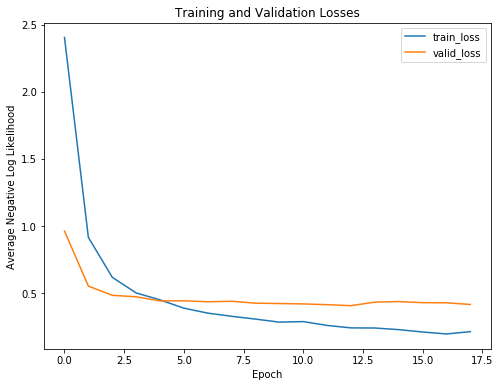

In [32]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

As expected, the training loss decreases continually with epochs. At a certain point however, the validation loss stops decreasing. There is not a massive amount of overfitting, likely because we were using Dropout. With the divergence in losses, there is likely not much more to gain from further training.

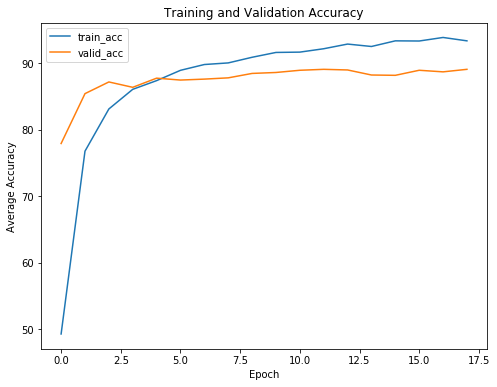

In [33]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

As with the losses, the training accuracy increases (nearly to perfect) while the validation accuracy plateaus. The model is able to achieve above 80% accuracy right away, an indication that the convolution weights learned on Imagenet were able to easily transfer to our dataset.

# Saving Model

The `train` function saves the best model `state_dict()` which are the weights of the model. To save more information about the model, we use the below function. 

In [34]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [35]:
save_checkpoint(model, path=checkpoint_path)

## Load in a Checkpoint

Now we need to write the function to load in the checkpoint. This just takes in a `path` and returns a model from a saved checkpoint.

In [37]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [38]:
model, optimizer = load_checkpoint(path=checkpoint_path)

if multi_gpu:
    summary(model.module, input_size=(3, 224, 224), batch_size=batch_size)
else:
    summary(model, input_size=(3, 224, 224), batch_size=batch_size)

135,335,076 total parameters.
1,074,532 total gradient parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 2

We can now use these two functions to save and load in a complete model. We can use this model to continue training. 

In [39]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Model has been trained for: 18 epochs.

Epoch: 1	100.00% complete. 33.04 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.2327 	Validation Loss: 0.4273
		Training Accuracy: 92.66%	 Validation Accuracy: 88.46%
Epoch: 3	100.00% complete. 32.77 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.2055 	Validation Loss: 0.4263
		Training Accuracy: 93.60%	 Validation Accuracy: 88.74%
Epoch: 5	100.00% complete. 32.01 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.1977 	Validation Loss: 0.4496
		Training Accuracy: 93.70%	 Validation Accuracy: 88.88%

Early Stopping! Total epochs: 5. Best epoch: 0 with loss: 0.42 and acc: 88.88%
290.51 total seconds elapsed. 48.42 seconds per epoch.


Further training is unlikely to improve the validation results. Let's move to inference.

# Inference

After the model has been trained to the point on no more improvement on the validation data, we need to test it on data it has never seen. Early stopping with a validation set does decrease overfitting to the training set, but at the cost of potentially overfitting to the validation data. For a final estimate of the model's performance, we need to use the hold out testing data. 
Here, we'll look at individual predictions along with loss and accuracy on the entire testing dataset. 

This function processes an image path into a PyTorch tensor for predictions. It applies the same transformations as was done to the validation data: cropping (center) and normalizing with means and standard deviations.

In [40]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [41]:
x = process_image(testdir + 'dragonfly/image_0015.jpg')
x.shape

torch.Size([3, 224, 224])

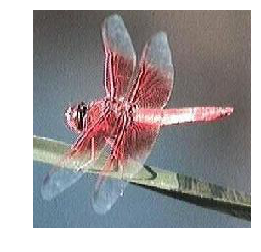

In [42]:
ax, image = imshow_tensor(x)

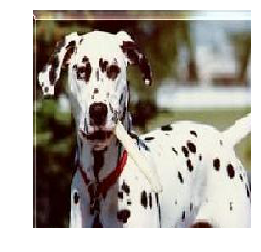

In [43]:
ax, image = imshow_tensor(process_image(testdir + 'dalmatian/image_0053.jpg'))

## Function to make predictions

The next function makes predictions on a single image. It will return the top probabilities and classes. 

In [44]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

This function can be used to pick a random test image. 

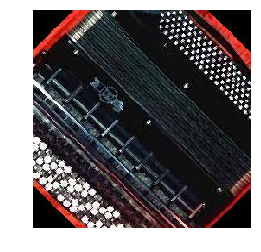

In [45]:
np.random.seed = 100


def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = testdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


_ = imshow_tensor(process_image(random_test_image()))

In [46]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
img.shape

torch.Size([3, 224, 224])

In [47]:
top_p, top_classes, real_class

(array([0.615789  , 0.35459077, 0.01252878, 0.00679292, 0.00269399],
       dtype=float32),
 ['ceiling_fan', 'gramophone', 'anchor', 'chair', 'octopus'],
 'ceiling_fan')

In [48]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
top_p, top_classes, real_class

(array([9.9574465e-01, 9.7864203e-04, 9.5386576e-04, 6.3906156e-04,
        6.0763489e-04], dtype=float32),
 ['pizza', 'brain', 'lobster', 'garfield', 'nautilus'],
 'pizza')

### Function to Display Predictions

This function displays the picture along with the `topk` predictions from the model. The title over the image displays the true class.

In [49]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

23 training images for barrel.


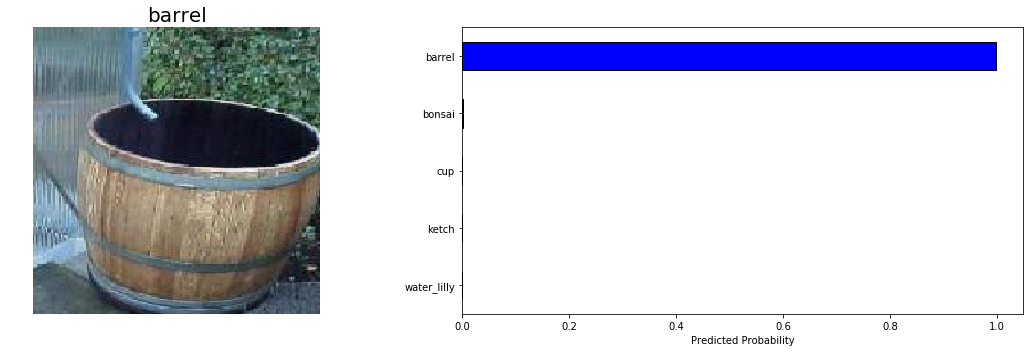

In [52]:
display_prediction(random_test_image(), model, topk=5)

398 training images for motorbikes.


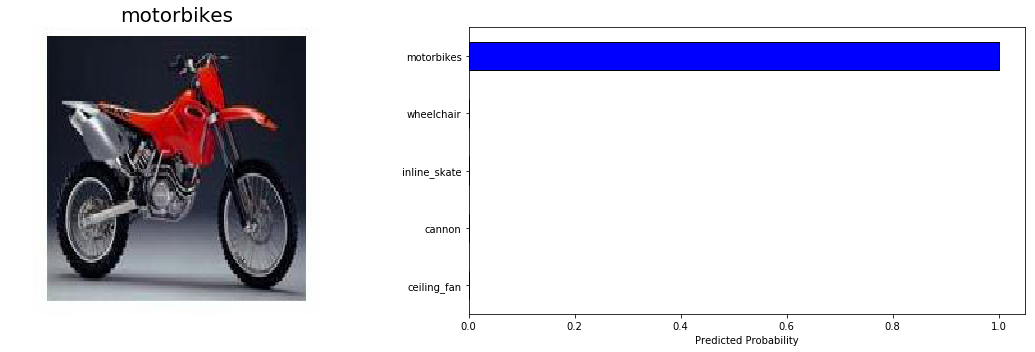

In [53]:
display_prediction(random_test_image(), model, topk=5)

# Testing Accuracy

Image identification models are usually assessed in terms of topk accuracy (for example the vgg16 model gets 28.41% top1 error and 9.62% top5 error on Imagenet). We'll assess out model by the top1 and top5 accuracy, that is, the percentage of predictions it gets exactly correct, and the percentage of predictions where the real class is in the top 5 actual classes.

The function below computes accuracy for a prediction and a target in terms of topk.

In [54]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [55]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model(features.to('cuda')), targets, topk=(1, 5))
else:
    accuracy(model(features), targets, topk=(1, 5))

[89.84375, 99.21875]

## Function to Evaluate Model Over All Classes

The next function iterates through the testing set in order to make predictions for each image. It calculates performance for each category.

In [56]:
def evaluate(model, test_loader, criterion, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

In [57]:
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results = evaluate(model, dataloaders['test'], criterion)
results.head()

class        top1        top5      loss
0  accordion  100.000000  100.000000  0.024399
1  airplanes   99.500000  100.000000  0.025006
2     anchor   18.181818   63.636364  2.895863
3        ant   36.363636   81.818182  2.266077
4     barrel   83.333333  100.000000  0.479768

## Test Results

We'd expect the model to do better on those classes for which it had the most training images. We can see if that is the case.

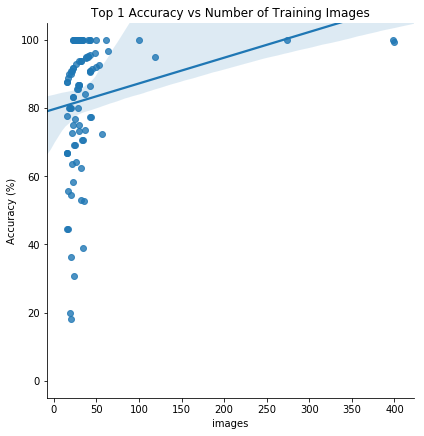

In [58]:
results = results.merge(cat_df, left_on='class', right_on='category').\
    drop(columns=['category'])

# Plot using seaborn
sns.lmplot(
    y='top1', x='n_train', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 1 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)

In [59]:
print('Category with minimum accuracy.')
results.loc[results['top1'].idxmin]

print('Category with minimum images.')
results.loc[results['n_train'].idxmin]

Category with minimum accuracy.


class       anchor
top1       18.1818
top5       63.6364
loss       2.89586
n_train         20
n_valid         11
n_test          11
Name: 2, dtype: object

Category with minimum images.


class      inline_skate
top1               87.5
top5                100
loss           0.221262
n_train              15
n_valid               8
n_test                8
Name: 49, dtype: object

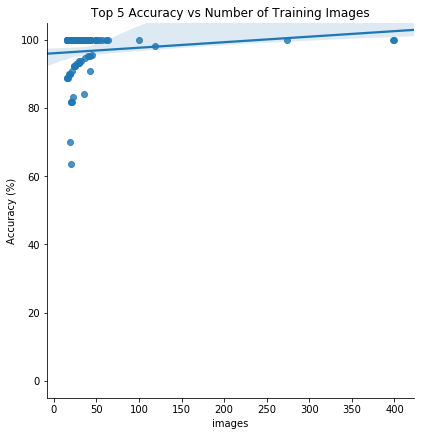

In [60]:
sns.lmplot(
    y='top5', x='n_train', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 5 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)

It looks like there is some relationship between the number of training images and the accuracy. However, there are a few classes with limited images in which the model does quite well.

In [61]:
# Weighted column of test images
results['weighted'] = results['n_test'] / results['n_test'].sum()

# Create weighted accuracies
for i in (1, 5):
    results[f'weighted_top{i}'] = results['weighted'] * results[f'top{i}']

# Find final accuracy accounting for frequencies
top1_weighted = results['weighted_top1'].sum()
top5_weighted = results['weighted_top5'].sum()
loss_weighted = (results['weighted'] * results['loss']).sum()

print(f'Final test cross entropy per image = {loss_weighted:.4f}.')
print(f'Final test top 1 weighted accuracy = {top1_weighted:.2f}%')
print(f'Final test top 5 weighted accuracy = {top5_weighted:.2f}%')

Final test cross entropy per image = 0.3772.
Final test top 1 weighted accuracy = 88.65%
Final test top 5 weighted accuracy = 98.00%


It's probably worth looking at the categories where the model is worst. 

24 training images for crocodile.
24 training images for crocodile.
24 training images for crocodile.


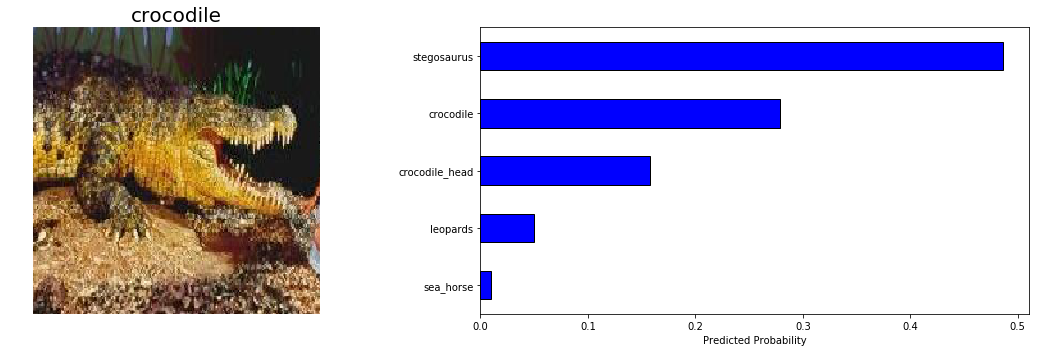

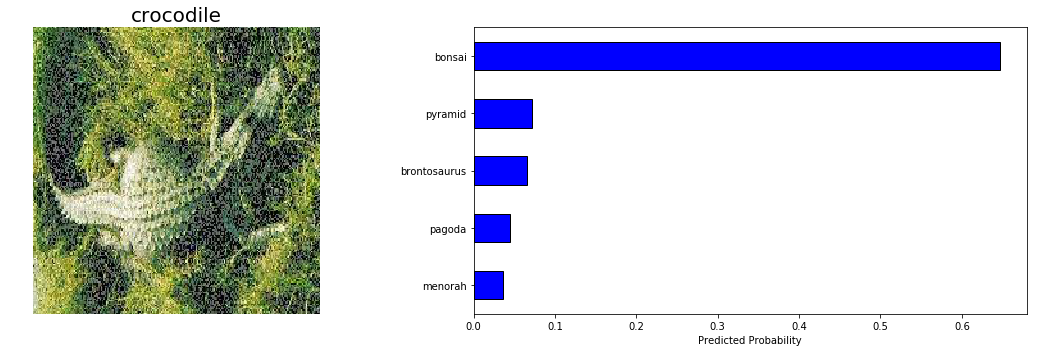

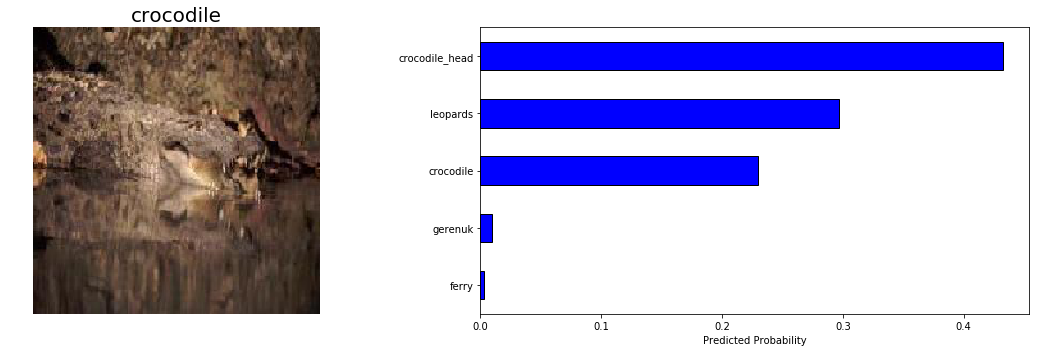

In [62]:
croc1 = '/home/wjk68/test/crocodile/image_0002.jpg'
croc2 = '/home/wjk68/test/crocodile/image_0004.jpg'
croc3 = '/home/wjk68/test/crocodile/image_0006.jpg'

display_prediction(croc1, model, 5)
display_prediction(croc2, model, 5)
display_prediction(croc3, model, 5)

Given the subtle distinction between `crocodile` and `crocodile_head`, I'd say that this model does pretty well! The ultimate bar in image recognition is human level, and our model is nearly there. 

In [70]:
def display_category(model, category, n=4):
    """Display predictions for a category    
    """
    category_results = results.loc[results['class'] == category]
    print(category_results.iloc[:, :6], '/n')

    images = np.random.choice(
        os.listdir(testdir + category + '/'), size=4, replace=False)

    for img in images:
        display_prediction(testdir + category + '/' + img, model, 5)

    class       top1       top5      loss  n_train  n_valid
2  anchor  18.181818  63.636364  2.895863       20       11 /n
20 training images for anchor.
20 training images for anchor.
20 training images for anchor.
20 training images for anchor.


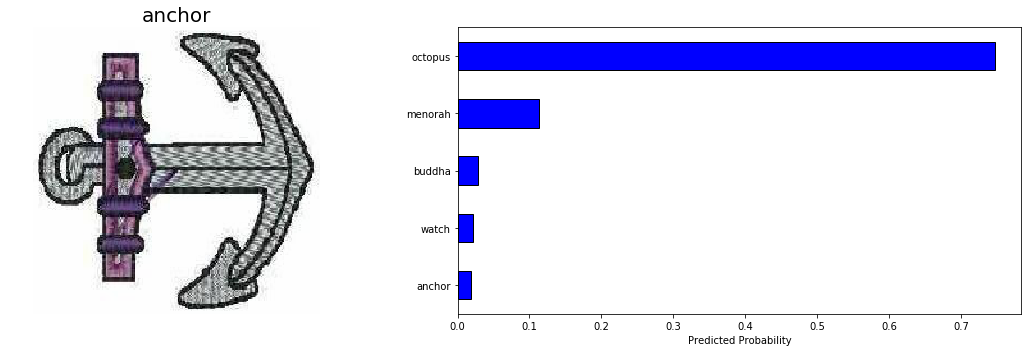

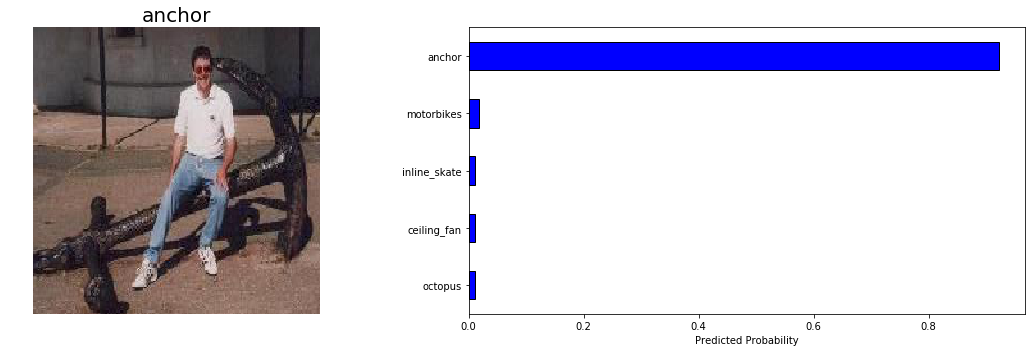

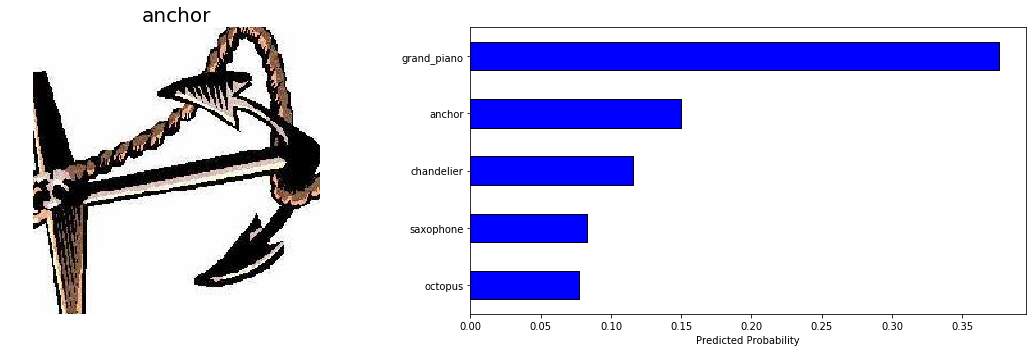

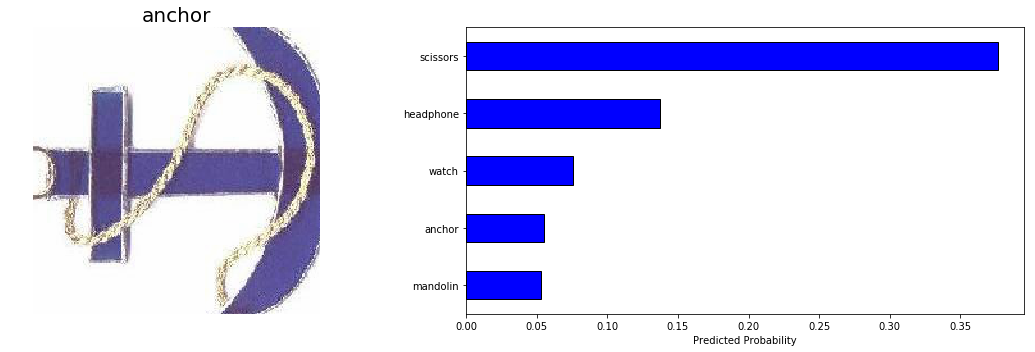

In [72]:
display_category(model, 'anchor')

       class       top1   top5      loss  n_train  n_valid
59  mandolin  90.909091  100.0  0.420903       21       11 /n
21 training images for mandolin.
21 training images for mandolin.
21 training images for mandolin.
21 training images for mandolin.


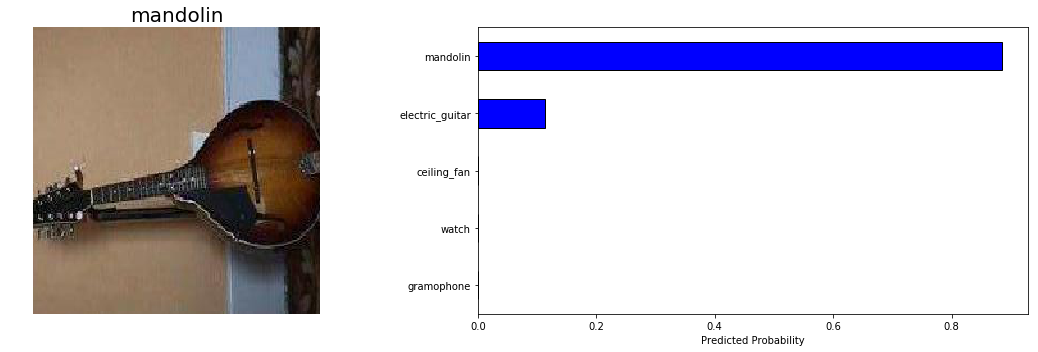

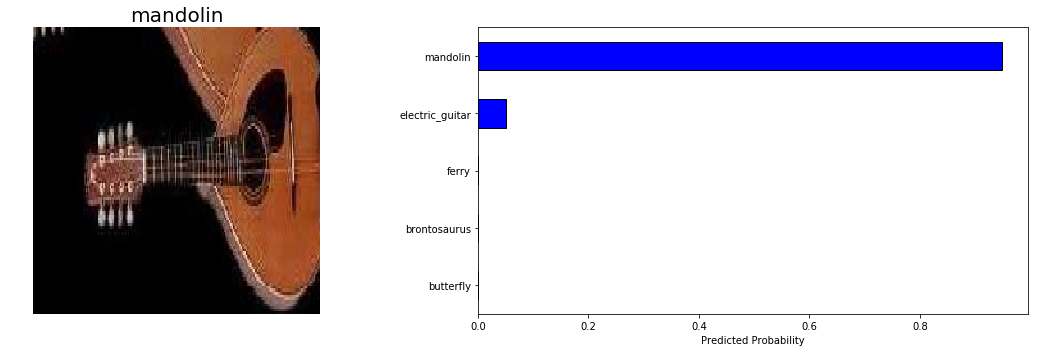

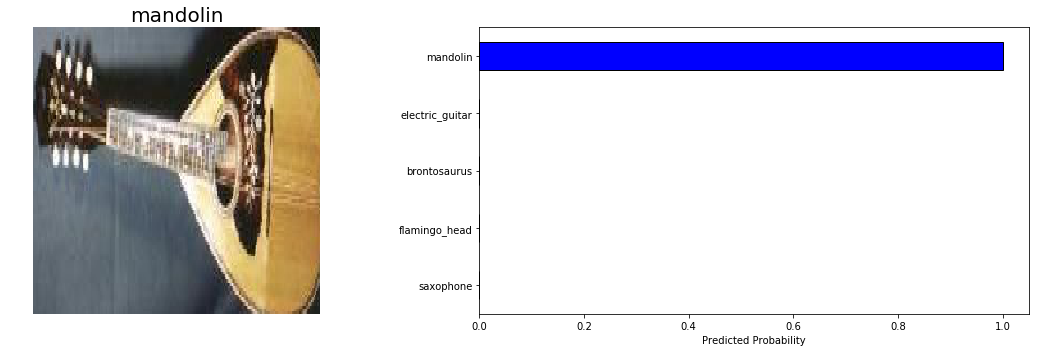

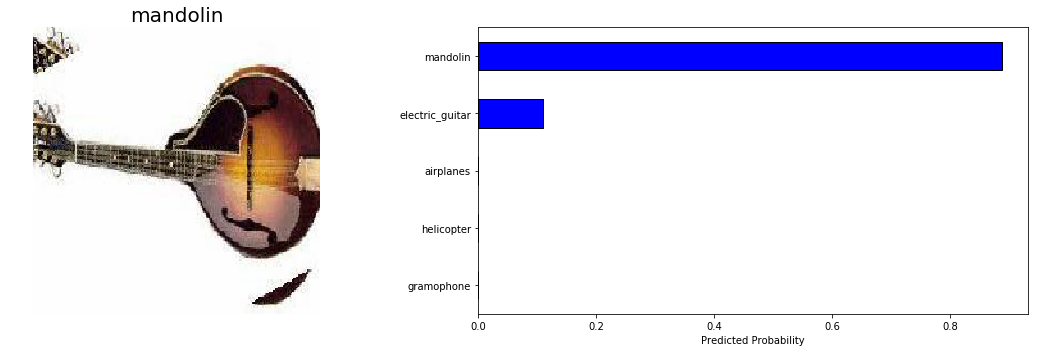

In [73]:
display_category(model, 'mandolin')

# Conclusions

This project taught us the basics of using PyTorch and pretrained neural networks for image recognition. We saw how to take a network that was trained on a large set of images and apply it successfully to a different task. Along the way, we learned a number of useful concepts for working with cnns in PyTorch including how to get our data into a model. The end result is a capable model trained in far less time than one trained from starting weights. 

Some of the ideas covered in this notebook were:

* PyTorch basics
* Data transformations 
* Training data augmentation
* Transfer Learning for object recognition
* Training a PyTorch model with early stopping on a validation set
* Inference using a PyTorch model


Truly, we live in an incredible age for deep learning with the wide availability of resources, and it's only getting better! Hopefully, this notebook has prepared you to take on your own deep learning challenges with PyTorch. 